In [108]:
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision.models import resnet18
from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram, plot_spectrogram
import IPython.display as Ipd

### Bridge2AI dataset

In [109]:
dataset = VBAIDataset('./bids_with_sensitive_recordings')


### Dataset split
- 80% for training
- 10% for validation
- 10% for testing

In [110]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
all_identities = sorted(participant_df['record_id'].to_numpy().tolist())

N = len(all_identities)

train_identities = set(all_identities[:int(0.8*N)])
val_identities = set(all_identities[int(0.8*N):int(0.9*N)])
test_identities = set(all_identities[int(0.9*N):])

print('train:', len(train_identities))
print('val:', len(val_identities))
print('test:', len(test_identities))

train: 142
val: 18
test: 18


### Create PyTorch dataset of prolonged vowel audios with age and airway stenosis labels

In [111]:
qs = dataset.load_questionnaires('recordingschema')
q_dfs = []
for i, questionnaire in enumerate(qs):
    df = dataset.questionnaire_to_dataframe(questionnaire)
    df['dataframe_number'] = i
    q_dfs.append(df)
    i += 1
recordingschema_df = pd.concat(q_dfs)
recordingschema_df = pd.pivot(recordingschema_df, index='dataframe_number', columns='linkId', values='valueString')

person_session_pairs = recordingschema_df[['record_id', 'recording_session_id']].to_numpy().astype(str)
person_session_pairs = np.unique(person_session_pairs, axis=0).tolist()

print('Found {} person/session pairs'.format(len(person_session_pairs)))

Found 204 person/session pairs


In [112]:
import torch
import torch.nn.functional as F

class MySpecgramDataset(torch.utils.data.Dataset):
	def __init__(self, identities, dataset, person_session_pairs, segment_size=3):
		self.segment_size = segment_size
		
		# get age and airway stenosis classification for all subjects
		participant_df = dataset.load_and_pivot_questionnaire('participant')
		age_df = participant_df[['record_id', 'age']].to_numpy()
		airway_stenosis_df = participant_df[['record_id', 'airway_stenosis']].to_numpy()
        
		age_dict = {}
		for person_id, age in age_df:
			age_dict[str(person_id)] = float(age)
		airway_stenosis_dict = {}
		for person_id, airway_stenosis in airway_stenosis_df:
			airway_stenosis_dict[str(person_id)] = float(airway_stenosis)

		# get all prolonged vowel audios
		self.audio_files = []
		self.age = []
		self.airway_stenosis = []
        
		for person_id, session_id in person_session_pairs:
			if person_id not in identities:
				continue
			vowel_audios = [str(x) for x in dataset.find_audio(person_id, session_id) if str(x).endswith('-Prolonged-vowel.wav')]
			self.audio_files += vowel_audios
			self.age += [age_dict[person_id]]*len(vowel_audios)
			self.airway_stenosis += [airway_stenosis_dict[person_id]]*len(vowel_audios)

	def __len__(self):
		return len(self.audio_files)

	def __getitem__(self, idx):
		audio = Audio.from_file(self.audio_files[idx])
		audio = audio.to_16khz()
		# get middle K seconds if audio is too long, pad with zeros if it is too short
		if audio.signal.size(0) > self.segment_size*16000:
			d = (audio.signal.size(0)-self.segment_size*16000)//2
			audio.signal = audio.signal[d:d+self.segment_size*16000]
		else:
			audio.signal = torch.nn.functional.pad(audio.signal, (0,self.segment_size*16000-audio.signal.size(0)), mode='constant', value=0)

		win_length = 30
		hop_length = 10
		nfft = 512
		features_specgram = specgram(audio, win_length=win_length, hop_length=hop_length, n_fft=nfft)
		features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10)))
		
		# I add this to reshape the image
		features_specgram = torch.nn.functional.interpolate(features_specgram.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)

		

		return {'signal': features_specgram, 'age': self.age[idx], 'airway_stenosis': self.airway_stenosis[idx]}

tensor([76., 65., 38., 64., 66., 55., 76., 62.], dtype=torch.float64) tensor([0., 0., 0., 0., 0., 1., 1., 0.], dtype=torch.float64)
image shape:  torch.Size([256, 256])
Batch shape:  torch.Size([8, 256, 256])


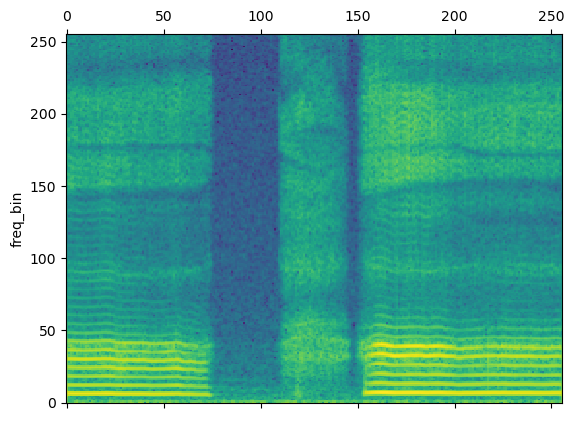

In [113]:
train_dataset = MySpecgramDataset(train_identities, dataset, person_session_pairs)
val_dataset = MySpecgramDataset(val_identities, dataset, person_session_pairs)
test_dataset = MySpecgramDataset(test_identities, dataset, person_session_pairs)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

for batch in train_dataloader:
	print(batch['age'], batch['airway_stenosis'])
	print("image shape: ", batch['signal'][0].T.shape)
	print("Batch shape: ", batch['signal'].shape)
	plot_spectrogram(batch['signal'][0].T)
	
	break

### Change batch size from (8, 256, 256) to (18, 8, 256, 256)
I did this to see if now it is compatiable with the model or not. Because in the example they used image with this shape: (20, 3, 256, 256). 

Skipping batch 18 because it has 1 samples but expected 8
Combined Tensor shape:  torch.Size([18, 8, 256, 256])


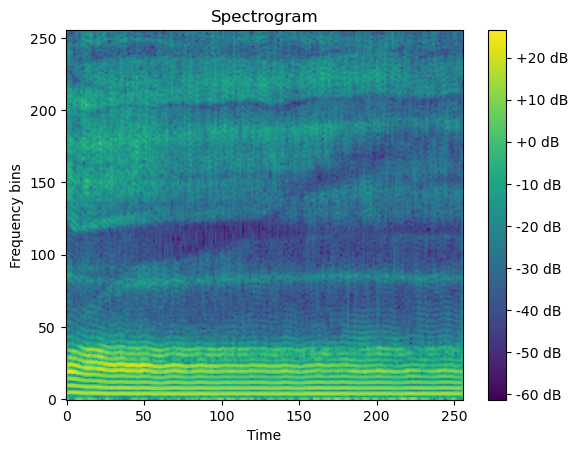

In [106]:
import torch
import matplotlib.pyplot as plt

def plot_spectrogram(spectrogram):
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.title("Spectrogram")
    plt.ylabel("Frequency bins")
    plt.xlabel("Time")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Initialize an empty list to collect the batches
all_batches = []

# Define the desired shape after padding
desired_shape = (8, 256, 256)

# Iterate through the data loader
for i, batch in enumerate(train_dataloader):
    if i >= 19:
        break
    
    signal = batch['signal']
    
    # Check if the batch has the expected number of samples
    if signal.shape[0] != desired_shape[0]:
        print(f"Skipping batch {i} because it has {signal.shape[0]} samples but expected {desired_shape[0]}")
        continue
    
    # Pad or reshape each signal to match desired_shape
    if signal.shape != desired_shape:
        # Assuming padding is necessary
        padded_signal = torch.nn.functional.pad(signal, (0, 10))
    else:
        padded_signal = signal
    
    # Append the padded batch to the list
    all_batches.append(padded_signal)

# Stack all valid batches along a new dimension
combined_tensor = torch.stack(all_batches, dim=0)

print("Combined Tensor shape: ", combined_tensor.shape)

# Plot the spectrogram of the first signal in the first batch
plot_spectrogram(combined_tensor[0, 0].T)




### ViT model 

In [107]:
import torch
from vit_pytorch import ViT
from vit_pytorch.mpp import MPP

model = ViT(
    image_size=256,
    patch_size=32,
    num_classes=2,
    dim=1024,
    depth=6,
    heads=8,
    mlp_dim=2048,
    dropout=0.1,
    emb_dropout=0.1
)

mpp_trainer = MPP(
    transformer=model,
    patch_size=32,
    dim=1024,
    mask_prob=0.15,          # probability of using token in masked prediction task
    random_patch_prob=0.30,  # probability of randomly replacing a token being used for mpp
    replace_prob=0.50,       # probability of replacing a token being used for mpp with the mask token
)

opt = torch.optim.Adam(mpp_trainer.parameters(), lr=3e-4)

def sample_unlabelled_images():
    return torch.FloatTensor(20, 3, 256, 256).uniform_(0., 1.)

for _ in range(100):
    images = combined_tensor
    loss = mpp_trainer(images)
    opt.zero_grad()
    loss.backward()
    opt.step()

# save your improved network
torch.save(model.state_dict(), './pretrained-net.pt')

RuntimeError: shape mismatch: value tensor of shape [3072] cannot be broadcast to indexing result of shape [87, 8192]

In [76]:
torch.save(model.state_dict(), './vit_transformer_model.pth')

### Training

my old code for transformer. I did not used it 

In [19]:
def eval(model, dataloader):
	model.eval()
	acc = 0
	for batch in dataloader:
		with torch.no_grad():
			outputs = torch.mean(torch.nn.functional.sigmoid(model(batch['signal'])),dim=1).squeeze(1)
		for i in range(len(batch['signal'])):
			if outputs[i].item() > 0.5:
				acc += batch['airway_stenosis'][i]
			else:
				acc += 1.0-batch['airway_stenosis'][i]
	return acc/len(dataloader.dataset)	

num_epochs = 100
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, weight_decay=5e-5)

best_val_acc = 0
for epoch in range(num_epochs):
	transformer.train()
	
	closs = []
	for batch in train_dataloader:
		optimizer.zero_grad()
		outputs = torch.mean(torch.nn.functional.sigmoid(transformer(batch['signal'])),dim=1).squeeze(1)
		loss = torch.nn.functional.binary_cross_entropy(outputs, batch['airway_stenosis'].float())
		closs += [loss.item()]*len(batch['signal'])
		loss.backward()
		optimizer.step()

	val_acc = eval(transformer, val_dataloader)
	print('Epoch:{} TrainLoss:{:.4f} TrainACC:{:.4f} ValACC:{:.4f}'.format(epoch+1, sum(closs)/len(closs), eval(transformer, train_dataloader), val_acc))

	if val_acc >= best_val_acc:
		best_val_acc = val_acc
		torch.save(transformer.state_dict(), './my_transformer_model.pth')
		print('Saved!')

torch.Size([8, 301, 257])
torch.Size([8, 301, 256])
torch.Size([8, 301, 256])
torch.Size([8, 301, 256])
torch.Size([8, 301, 1])
torch.Size([8, 301, 257])
torch.Size([8, 301, 256])
torch.Size([8, 301, 256])
torch.Size([8, 301, 256])
torch.Size([8, 301, 1])
torch.Size([8, 301, 257])
torch.Size([8, 301, 256])
torch.Size([8, 301, 256])
torch.Size([8, 301, 256])
torch.Size([8, 301, 1])
torch.Size([8, 301, 257])
torch.Size([8, 301, 256])
torch.Size([8, 301, 256])
torch.Size([8, 301, 256])
torch.Size([8, 301, 1])
torch.Size([8, 301, 257])
torch.Size([8, 301, 256])
torch.Size([8, 301, 256])
torch.Size([8, 301, 256])
torch.Size([8, 301, 1])
torch.Size([8, 301, 257])
torch.Size([8, 301, 256])
torch.Size([8, 301, 256])
torch.Size([8, 301, 256])
torch.Size([8, 301, 1])
torch.Size([8, 301, 257])
torch.Size([8, 301, 256])
torch.Size([8, 301, 256])
torch.Size([8, 301, 256])
torch.Size([8, 301, 1])
torch.Size([8, 301, 257])
torch.Size([8, 301, 256])
torch.Size([8, 301, 256])
torch.Size([8, 301, 256])


KeyboardInterrupt: 

### Testing

In [78]:
def eval(model, dataloader):
	model.eval()
	acc = 0
	for batch in dataloader:
		with torch.no_grad():
			outputs = torch.mean(torch.nn.functional.sigmoid(model(batch['signal'])),dim=1).squeeze(1)
		for i in range(len(batch['signal'])):
			if outputs[i].item() > 0.5:
				acc += batch['airway_stenosis'][i]
			else:
				acc += 1.0-batch['airway_stenosis'][i]
	return acc/len(dataloader.dataset)	

model.load_state_dict(torch.load('./vit_transformer_model.pth'))
test_acc = eval(model, test_dataloader)
print('TestACC:{:.4f}'.format(test_acc))

KeyError: 3

In [79]:
model.eval()
acc = [0, 0]
total = [0, 0]
for batch in test_dataloader:
	with torch.no_grad():
		outputs = torch.mean(torch.nn.functional.sigmoid(model(batch['signal'])),dim=1).squeeze(1)
	for i in range(len(batch['signal'])):
		total[int(batch['airway_stenosis'][i])] += 1
		if outputs[i].item() > 0.5:
			acc[int(batch['airway_stenosis'][i])] += batch['airway_stenosis'][i]
		else:
			acc[int(batch['airway_stenosis'][i])] += 1.0-batch['airway_stenosis'][i]

print('Class #0 ({}) ACC:{:.4f} Class #1 ({}) ACC:{:.4f}'.format(total[0], acc[0]/total[0], total[1], acc[1]/total[1]))

KeyError: 3